# Generating Faces Using a Generative Adversarial Network

## Creating A Generative Adversarial Network

### Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import random

from PIL import Image
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense
from tensorflow.keras.layers import Dropout, Flatten, Input, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tqdm import tqdm

### Define The Discriminator

In [2]:
discriminator_conv_filters = [64, 64, 128, 128]
discriminator_conv_strides = [2, 2, 2, 1]

discriminator_input = Input(shape = (32, 32, 3), name = 'discriminator_input')
x = discriminator_input

for i in range(4):
    
    x = Conv2D(
            filters = discriminator_conv_filters[i], 
            strides = discriminator_conv_strides[i], 
            padding = 'same',
            kernel_size = 5
        )(x)
    x = Activation('relu')(x)
    x = Dropout(rate = 0.4)(x)
    
x = Flatten()(x)
discriminator_output = Dense(1, activation = 'sigmoid')(x)
discriminator = Model(discriminator_input, discriminator_output)

### Define The Generator

In [3]:
generator_conv_filters = [16, 8, 3, 3]

generator_input = Input(shape = (200, ))
x = generator_input
x = Dense(np.prod((8, 8, 64)))(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)
x = Reshape((8, 8, 64))(x)

for i in range(4):
    if i < 2: x = UpSampling2D()(x)
    x = Conv2D(
        filters = generator_conv_filters[i],
        padding = 'same',
        kernel_size = 5
    )(x)
    if i < 3:
        x = BatchNormalization(momentum = 0.9)(x)
        x = Activation('relu')(x)
    else:
        x = Activation('sigmoid')(x)

generator_output = x
generator = Model(generator_input, generator_output)

### Define The Generative Adversarial Network Using The Discriminator and The Generator

In [4]:
# Compile model that trains the discriminator
discriminator.compile(optimizer = RMSprop(lr = 0.0008), loss = 'binary_crossentropy')

# Compile model that trains the generator
discriminator.trainable = False
model_input  = Input(shape = (200, ))
model_output = discriminator(generator(model_input))
model = Model(model_input, model_output)
model.compile(optimizer = RMSprop(lr = 0.0004), loss = 'binary_crossentropy')

## Faces dataset

### Sampling Images From A Directory

In [5]:
image_list = os.listdir('./images/dodie')
num_images = len(image_list)

def sample_image_batch(batch_size = 25):
    index_batch = random.sample(range(num_images), batch_size)
    image_batch = np.empty(shape = (batch_size, 32, 32, 3))
    
    for i, j in enumerate(index_batch):
        image_name = './images/dodie/' + image_list[j]
        image = Image.open(image_name)
        image = image.resize([32, 32])
        image = np.array(image) / 255
        image_batch[i] = image
        
    return image_batch

image_batch = sample_image_batch()

### Display Images

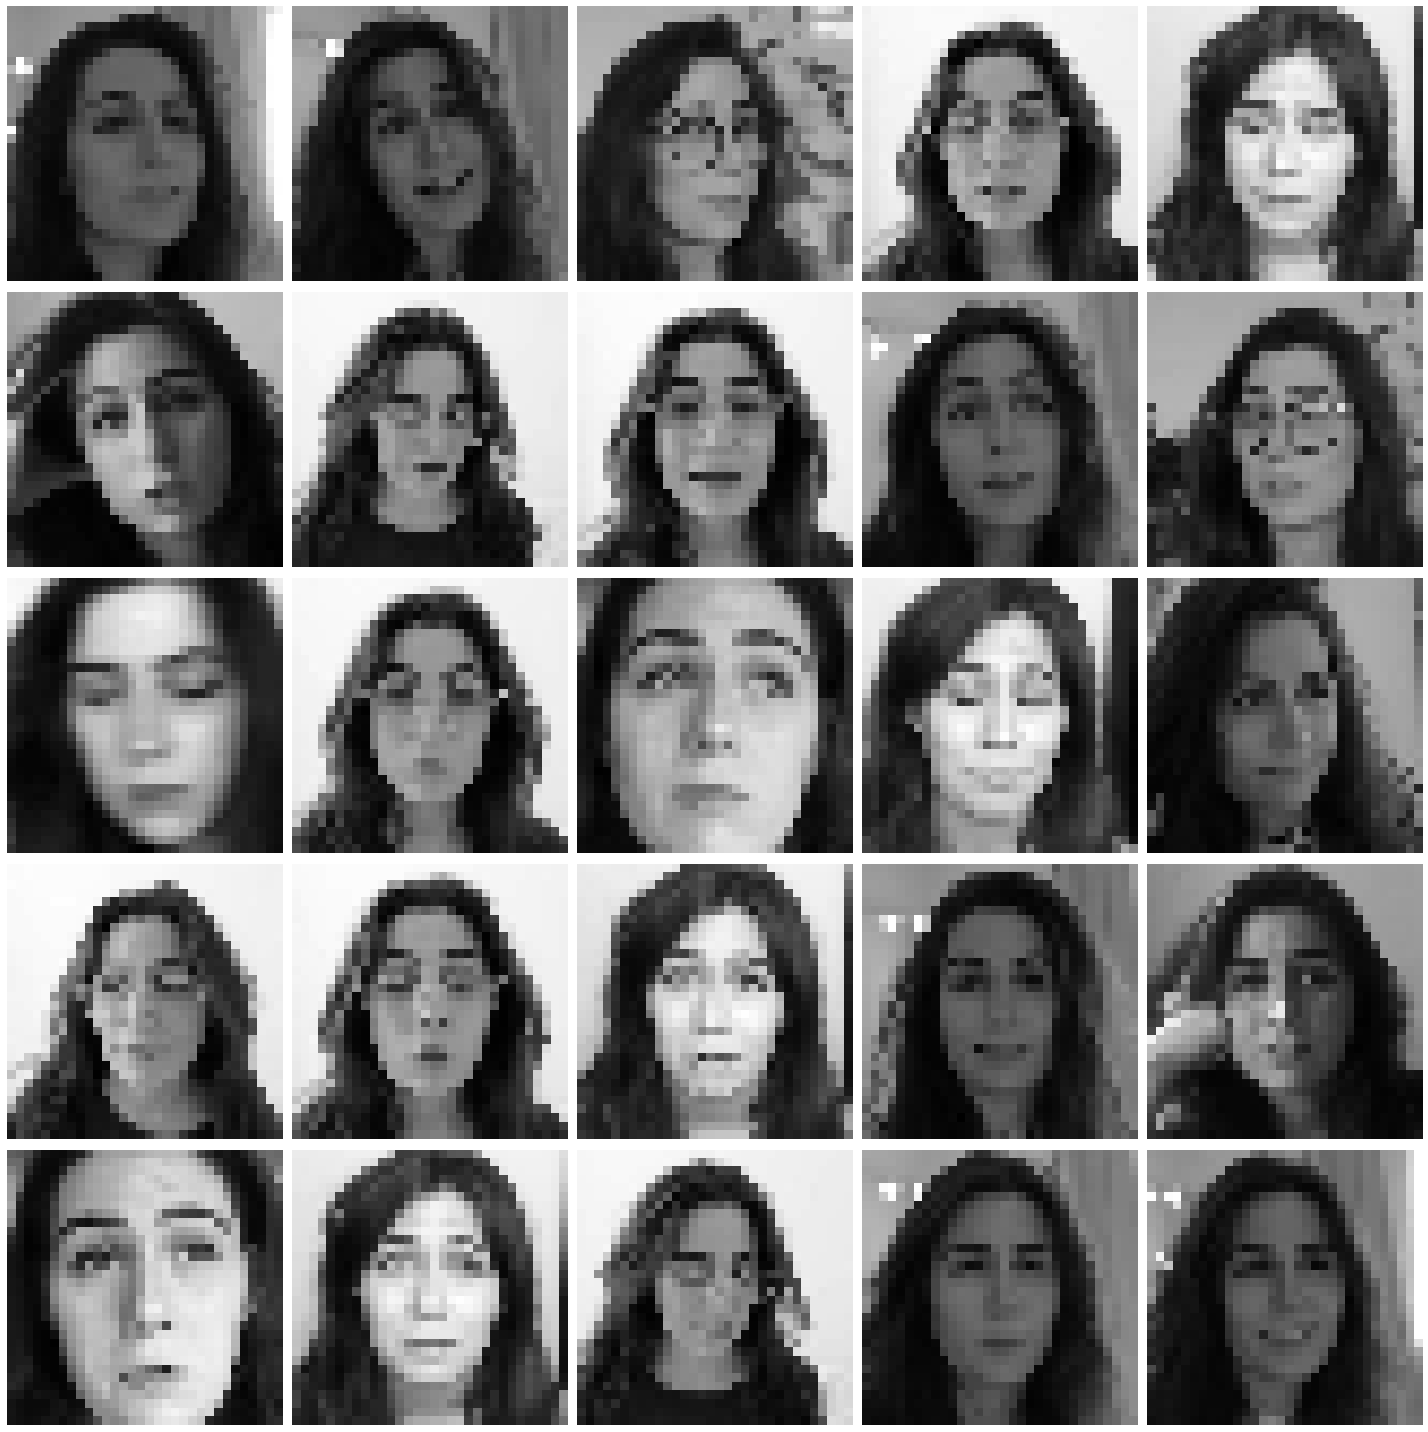

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(5, 5, figsize = (20, 20))
    axes = axes.flatten()
    
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images(image_batch)

## Training

In [7]:
epochs = 5000

for epoch in tqdm(range(epochs)):
    # Train Discriminator
    real = np.ones((25, 1))
    fake = np.zeros((25, 1))
    
    real_images = sample_image_batch()
    discriminator.train_on_batch(real_images, real)
    
    noise = np.random.normal(0, 1, (25, 200))
    fake_images = generator.predict(noise)
    discriminator.train_on_batch(fake_images, fake)
    
    # Train Generator
    noise = np.random.normal(0, 1, (25, 200))
    model.train_on_batch(noise, real)

100%|██████████| 5000/5000 [49:21<00:00,  1.69it/s]


## Results

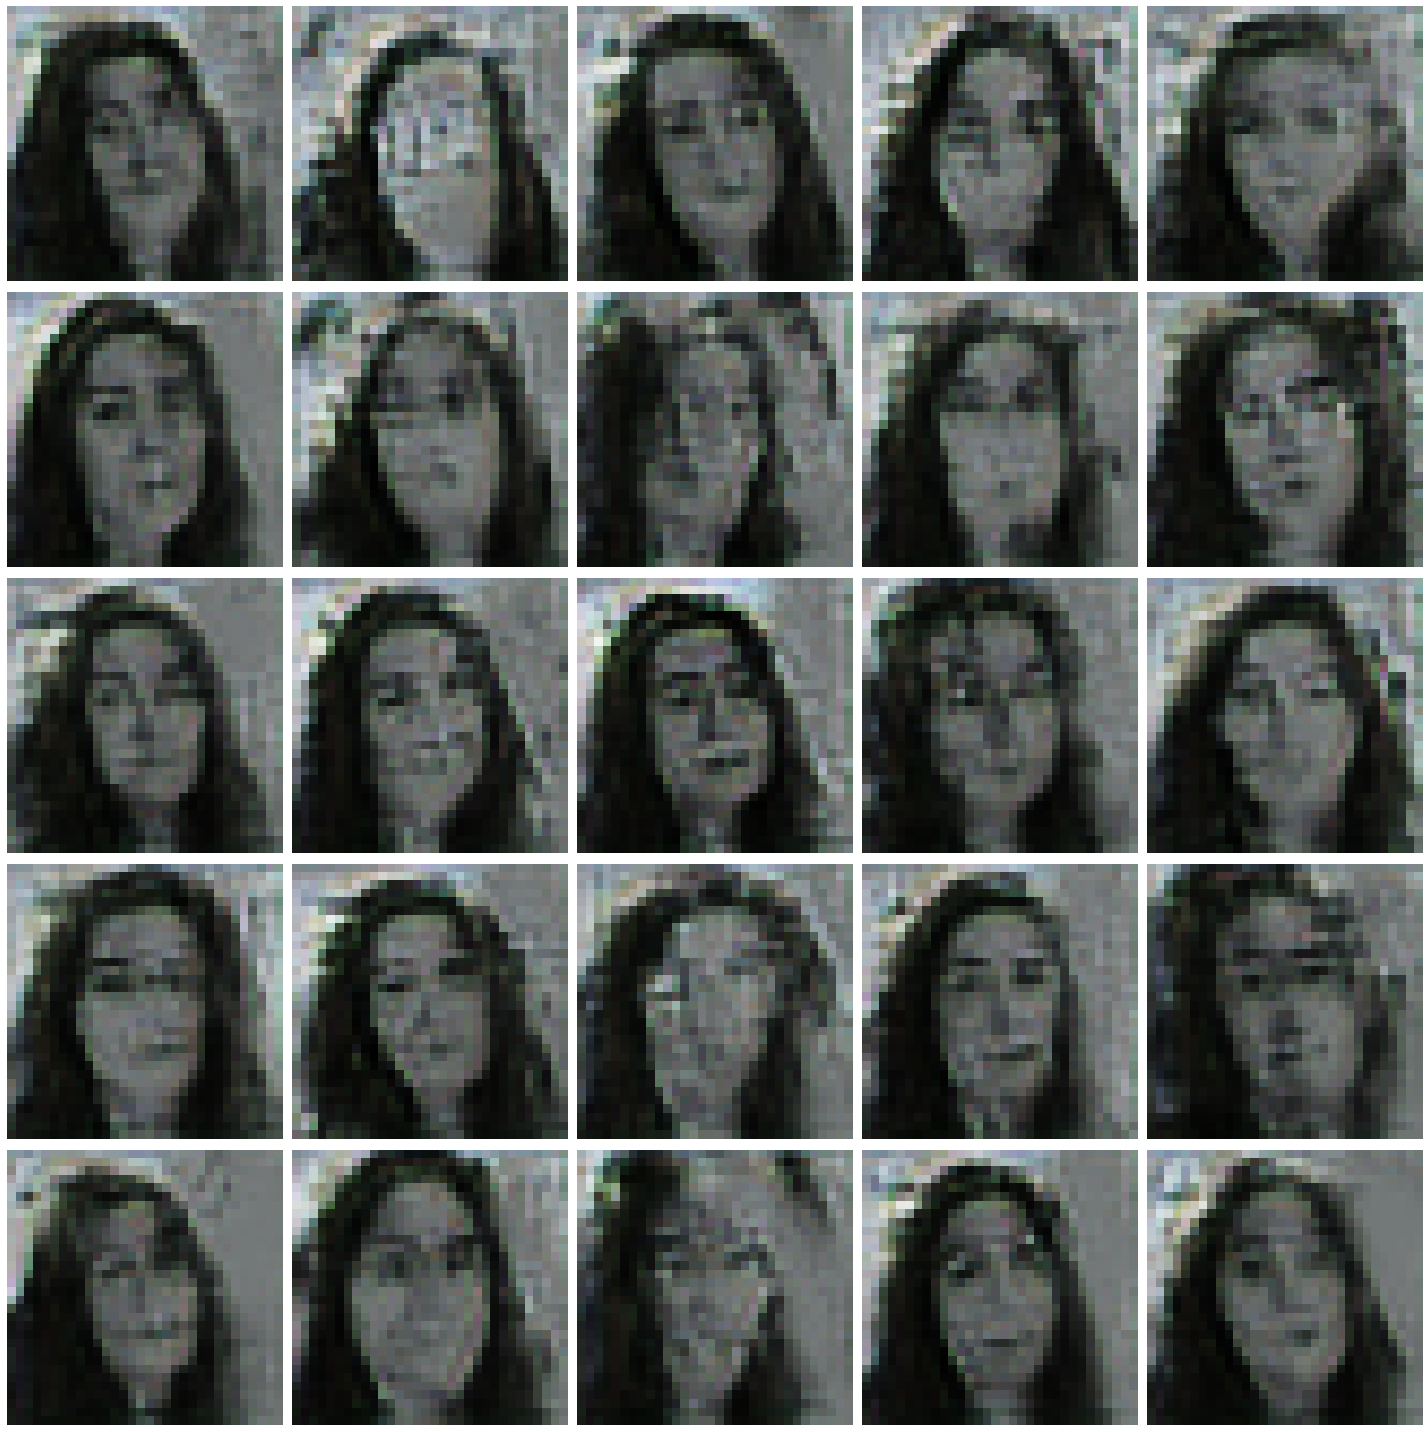

In [8]:
noise = np.random.normal(size = [25, 200])
generated_image = generator.predict(noise)

fig, axes = plt.subplots(5, 5, figsize = (20, 20))
i = 0
for row in range(0, 5):
    for col in range(0, 5):
        current_image = generated_image[i]
        axes[row, col].axis('off')
        axes[row, col].imshow(current_image)
        i += 1

plt.tight_layout()
plt.show()